In [1]:
'''
Author: Naixin && naixinguo2-c@my.cityu.edu.hk
Date: 2022-11-01 14:50:18
LastEditors: Naixin && naixinguo2-c@my.cityu.edu.hk
LastEditTime: 2022-11-01 14:52:17
FilePath: /Gtext/xiu/fixword_ex.ipynb
Description: 

'''

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import os
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy import sparse

##################### Could be changed part ##########################
sparse_folder = 'results_primary_news_sparse_multiyears/'
index_folder = 'results_primary_news_index_multiyears/'

sparse_file = '2005_2020_sparse/2005_2014_sparse_threecol.csv'
index_file = '2005_2020_index_news/2005_2014_index_news.csv'
word_file = '2005_2014_stemmed_word_count.csv'

######################################################################

######################## Could be put in the function module py file ########################
# Define a function to transform data from three columns to sparse matrix
def trans_data(sparse_data, news_data, word_data):
    '''
    :param sparse_data: the three column saved words DataFrame includes 'Row', 'Column', 'Value'
    :param news_data: news DataFrame includes 'Row_ID', 'permno', 'returnday_1', 'threedayreturn', 'title'
    :param word_data: words DataFrame includes 'WordIndex', 'final_word', 'TotalWordNum', 'TotalBodyNum'

    :return W_array: sparse matrix of word counts, n*k --> n: # of news, k: # of words
    :return r_array: return vector, length == # of news
    :return stkcd_array: permno vector, length == # of news
    :return date_array: date vector, length == # of news
    '''

    r_array = np.array(news_data['threedayreturn'])
    stkcd_array = np.array(news_data['permno'])
    date_array = np.array(news_data['returnday_1'])
    
    # Transform three columns to sparse matrix W
    newrowarray = np.array(sparse_data['Row'])
    newcolarray = np.array(sparse_data['Column'])
    newvaluearray = np.array(sparse_data['Value'])

    W_array = sparse.csr_matrix((newvaluearray, (newrowarray, newcolarray)), shape = (newrowarray[-1]+1, word_data.shape[0])).toarray()

    return W_array, r_array, stkcd_array, date_array

#############################################################################################

# Load in data set
df_sparse = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + sparse_folder + sparse_file)
df_newsindex = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + index_folder + index_file)
df_words = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + word_file)

W_train, r_train, stkcd, datearray = trans_data(df_sparse, df_newsindex, df_words)



In [2]:
'''
Author: Naixin && naixinguo2-c@my.cityu.edu.hk
Date: 2022-11-01 14:50:18
LastEditors: Naixin && naixinguo2-c@my.cityu.edu.hk
LastEditTime: 2022-11-04 09:13:18
FilePath: /Gtext/xiu/fixword_ex.ipynb
Description: 

'''
import heapq
from collections import Counter

def SESTM1(W_train, r_train, alpha_posnum, alpha_negnum, kappa):
    n, S = W_train.shape

    ###################Screening Part##############
    #####each year have appearance_word list#####
    # appearance_word = df_words.TotalBodyNum
    appearance_word = sum(W_train>0)
    print(np.quantile(appearance_word,kappa))

    # appearance_word = df_words.TotalBodyNum
    yearcount = dict(Counter([datearray[i][:4] for i in range(n)]))
    start = 0
    freq_index = []
    for key, value in yearcount.items():
        print(key, value)

        appearance_word0 = sum(W_train[start:start + value]>0)
        # freq_index = list({np.where(appearance_word0 > np.quantile(appearance_word0, kappa))[0]}.union(freq_index))
        print('print(np.quantile(appearance_word,kappa))',np.quantile(appearance_word0,kappa))
        freq_index =list(set(np.where(appearance_word0 >= np.quantile(appearance_word0,kappa))[0]).union(set(freq_index)))
        # print(len(appearance_word0),len(freq_index))
        start += value
            # print(len(freq_index))
    print(len(appearance_word),len(freq_index))
    print(len(freq_index))

    # print(np.quantile(appearance_word,kappa))
    # pi = sum(np.array([r_train[i] for i in freq_index])>0)/len(freq_index)
    pi = sum(r_train>0)/len(r_train)
    print('pi',pi)
    # pi=0.5
    WS_pos_index = []  #index of the positive sentiment word
    WS_neg_index = []  #index of the negative sentiment word
    fq_pos = {}
    fq_neg = {}

    for i in freq_index:
        # calculte f* to screen
        i_index = np.nonzero(W_train[:,i])[0] # count of word i appearance in all article
        # print(i)
        # print(len(i_index))
        # # print(df_words.TotalBodyNum[i])
        # print(appearance_word[i])
        num_i_index = len(i_index)
        f_r = sum(r_train[i_index]>0) # count of word i in all articles and having r>0   
        # print(f_r)
        # print(f_r/quantile_word[i])
        if f_r/num_i_index  >= pi:
        # if f_r/appearance_word[i] >= pi:
            # fq_pos[i] = f_r/appearance_word[i]  
            fq_pos[i] = f_r/num_i_index   
            # if  fq_pos[i] ==1:
            #     print(i,appearance_word[i])
        else:
            # fq_neg[i] = f_r/appearance_word[i]
            fq_neg[i] = f_r/num_i_index    
            # if  fq_neg[i] ==0:
            #     print(i,appearance_word[i])
        # if i ==2588:
        #     print( 'hi',f_r/num_i_index,f_r,num_i_index)
        # if i ==1670:
        #     print( 'hi',f_r/num_i_index,f_r,num_i_index)
    # print("fq_pos",fq_pos)
    # print('print(fq_neg)  ',fq_neg)  
    WS_pos_index = heapq.nlargest(alpha_posnum, fq_pos, key=lambda x: fq_pos[x])
    # print(len(WS_pos_index)) 
    WS_neg_index = heapq.nsmallest(alpha_negnum, fq_neg, key=lambda x: fq_neg[x])
    
    print([fq_pos[i] for i in WS_pos_index])
    print([fq_neg[i] for i in WS_neg_index])
    ###################Screening Part##############
    return WS_pos_index, WS_neg_index, fq_pos , fq_neg

WS_pos_index,WS_neg_index,fq_pos,fq_neg = SESTM1(W_train, r_train, 100, 100, 0.92)
# WS_pos_index,WS_neg_index = SESTM1(W_train, r_train, alpha_posnum, alpha_negnum, kappa)
# print(stkcd_array[WS_pos_index,:])
print([(df_words.final_word[i]) for i in WS_pos_index])
print([(df_words.final_word[i]) for i in WS_neg_index])

1643.4799999999996
2005 7799
print(np.quantile(appearance_word,kappa)) 41.0
2006 9856
print(np.quantile(appearance_word,kappa)) 31.0
2007 7924
print(np.quantile(appearance_word,kappa)) 25.0
2008 13471
print(np.quantile(appearance_word,kappa)) 107.0
2009 18451
print(np.quantile(appearance_word,kappa)) 185.47999999999956
2010 20887
print(np.quantile(appearance_word,kappa)) 193.0
2011 25028
print(np.quantile(appearance_word,kappa)) 237.0
2012 24819
print(np.quantile(appearance_word,kappa)) 256.47999999999956
2013 27750
print(np.quantile(appearance_word,kappa)) 247.47999999999956
2014 26351
print(np.quantile(appearance_word,kappa)) 269.47999999999956
23245 2517
2517
pi 0.5198644261144261
[0.6491477272727273, 0.619781631342325, 0.6009389671361502, 0.6006191950464397, 0.6, 0.5990338164251208, 0.5974025974025974, 0.5851063829787234, 0.5814814814814815, 0.5797546012269938, 0.5757825370675453, 0.571150097465887, 0.5708756652152879, 0.5677480916030534, 0.566420664206642, 0.5648780487804878, 0.56

(-0.5, 399.5, 199.5, -0.5)

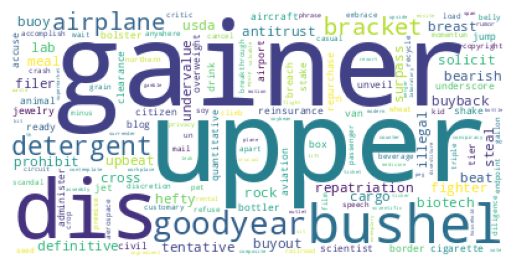

In [3]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image

fq_pos = {df_words.final_word[k]: v for k, v in fq_pos.items()}
# print(fq_pos0)
plt.imshow(WordCloud(background_color='white').generate_from_frequencies(frequencies=fq_pos))
plt.axis("off")


(-0.5, 399.5, 199.5, -0.5)

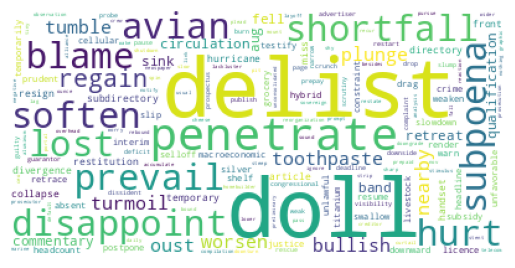

In [4]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
fq_neg = {df_words.final_word[k]: 1-v for k, v in fq_neg.items()}
        
plt.imshow(WordCloud(background_color='white').generate_from_frequencies(frequencies=fq_neg))
plt.axis("off")